In [1]:
import pandas as pd
import cv2
import tqdm
import os
import pickle

from transformers import AutoProcessor, AutoModelForCausalLM
import requests
import urllib.request
from PIL import Image
from matplotlib import pyplot as plt
%pylab inline

In [3]:
processor = AutoProcessor.from_pretrained("microsoft/git-base-coco")
model = AutoModelForCausalLM.from_pretrained("microsoft/git-base-coco")

/home/timur.abdrashitov/python_env/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


[2024-06-06 19:53:17,817] [INFO] [real_accelerator.py:191:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/home/timur.abdrashitov/python_env/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [4]:
yappy_hackton_dataset = pd.read_csv("yappy_hackaton_2024_400k.csv")

In [5]:
cnt_frames_to_prc = 1

In [6]:
if os.path.exists("cache_1.pickle"):
    with open("cache_1.pickle", "rb") as file:
        data_anno_out = pickle.load(file)
else:
    data_anno_out = {}

In [201]:
for ix_obj in tqdm.tqdm(range(len(yappy_hackton_dataset))):
    mp4_url = yappy_hackton_dataset.loc[ix_obj].link

    if mp4_url in data_anno_out:
        continue
        
    urllib.request.urlretrieve(mp4_url, mp4_url.split("/")[-2] + ".mp4")
    
    cap = cv2.VideoCapture(mp4_url.split("/")[-2] + ".mp4")

    sents = []
    i = 0
    while True:
     # Capture frame-by-frame
        ret, frame = cap.read()
        if not ret:
            break
        if i % int(cap.get(cv2.CAP_PROP_FRAME_COUNT) / cnt_frames_to_prc) == 0:
            frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
            pixel_values = processor(images=frame, return_tensors="pt").pixel_values
    
            generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
            generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
            sents.append(generated_caption)
    
        i += 1

    data_anno_out[mp4_url] = sents
        
    os.remove(mp4_url.split("/")[-2] + ".mp4")

    if ix_obj % 10 == 0:
        with open("cache_1.pickle", "wb") as file:
            pickle.dump(data_anno_out, file)

  1%|▎                                            | 2692/400000 [1:38:03<241:12:53,  2.19s/it]


KeyboardInterrupt: 

In [17]:
data_anno_out

{'https://cdn-st.rutubelist.ru/media/b0/e9/ef285e0241139fc611318ed33071/fhd.mp4': ['the game is set to be played by a team of players.'],
 'https://cdn-st.rutubelist.ru/media/39/6c/b31bc6864bef9d8a96814f1822ca/fhd.mp4': ['a 3d model of a 3d character wearing sunglasses.'],
 'https://cdn-st.rutubelist.ru/media/e9/e0/b47a9df14a5e97942715e5e705c0/fhd.mp4': ['the girl who was attacked by a man'],
 'https://cdn-st.rutubelist.ru/media/87/43/b11df3f344d0af773aac81e410ee/fhd.mp4': ['the singer is a singer and actress who is currently living.'],
 'https://cdn-st.rutubelist.ru/media/d1/e7/642dc2194fcdb69664f832d5f2dd/fhd.mp4': ['man in a white shirt and black suspenders'],
 'https://cdn-st.rutubelist.ru/media/e2/97/f9164f8a41479f961d64842154a7/fhd.mp4': ['a couple of women standing in a dance studio.'],
 'https://cdn-st.rutubelist.ru/media/0f/48/8a1ff7324073947a31e80f71d001/fhd.mp4': ['man standing in front of fireplace'],
 'https://cdn-st.rutubelist.ru/media/19/9c/98de3b4a4d9e83cb5dda828f899e/f

In [9]:
plt.imshow(frame)

NameError: name 'frame' is not defined

In [180]:
# url = "http://images.cocodataset.org/val2017/000000039769.jpg"
# image = Image.open(requests.get(url, stream=True).raw)

# pixel_values = processor(images=image, return_tensors="pt").pixel_values

# generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
# generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
# print(generated_caption)

In [10]:
import torch
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
model = AutoModel.from_pretrained("cointegrated/rubert-tiny2")
# model.cuda()  # uncomment it if you have a GPU

def embed_bert_cls(text, model, tokenizer):
    t = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**{k: v.to(model.device) for k, v in t.items()})
    embeddings = model_output.last_hidden_state[:, 0, :]
    embeddings = torch.nn.functional.normalize(embeddings)
    return embeddings[0].cpu().numpy()

/home/timur.abdrashitov/python_env/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/401 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.74M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/118M [00:00<?, ?B/s]

In [80]:
req_text = embed_bert_cls("человек в лифте", model,tokenizer)#elevator

In [81]:
from numpy import dot
from numpy.linalg import norm
dist = []
distk = []
min_dst = 1000000
min_dst_URL = None

for k in tqdm.tqdm(data_anno_out):
    text = data_anno_out[k]
    img_text = embed_bert_cls(text, model,tokenizer)

    dist.append(1 - dot(img_text, req_text)/(norm(img_text)*norm(req_text)))
    distk.append(k)

100%|███████████████████████████████████████████████████| 2691/2691 [00:02<00:00, 1120.63it/s]


In [82]:
req_text = embed_bert_cls("пожарный", model,tokenizer)
img_text  = embed_bert_cls("police officers stand on the streets.", model,tokenizer)
1 - dot(img_text, req_text)/(norm(img_text)*norm(req_text))

0.43313997983932495

In [83]:
for _ in np.argsort(dist)[:15]:
    print(distk[_], dist[_], data_anno_out[distk[_]])

https://cdn-st.rutubelist.ru/media/6e/5d/1196cc71428986eb5d91f97a8d4e/fhd.mp4 0.1969485878944397 ['man walking in a hallway']
https://cdn-st.rutubelist.ru/media/e2/9d/2d83afed4d9aaa9c4c0c51ab15c5/fhd.mp4 0.21603035926818848 ['person in a bathrobe']
https://cdn-st.rutubelist.ru/media/26/1a/d5a16a5f495a9d5b84cb2ff3d697/fhd.mp4 0.21603035926818848 ['person in a bathrobe']
https://cdn-st.rutubelist.ru/media/4e/76/c8f9225a4126903886607f9de775/fhd.mp4 0.22794198989868164 ['the man in the car']
https://cdn-st.rutubelist.ru/media/b5/68/76e87fd14f9db85b062626539fda/fhd.mp4 0.23285537958145142 ['a man in a car']
https://cdn-st.rutubelist.ru/media/89/c7/ab3fe88d44cab80766c784d511ec/fhd.mp4 0.23304492235183716 ['person in front of a car']
https://cdn-st.rutubelist.ru/media/76/cd/e788e0cc4ccfb6ad33b08b66f208/fhd.mp4 0.2340671420097351 ['person on a snowboard']
https://cdn-st.rutubelist.ru/media/fb/8a/3b8c45a04eab8fc9a313c482ee41/fhd.mp4 0.2340671420097351 ['person on a snowboard']
https://cdn-st.ru

In [207]:
data_anno_out["https://cdn-st.rutubelist.ru/media/f4/50/cbef16314b1f9096b464c38441e0/fhd.mp4"]

['how to make an orange from scratch']

In [ ]:
min_dst_URL

In [24]:
from diagrams import Diagram
from diagrams.aws.compute import EC2
from diagrams.aws.database import RDS
from diagrams.aws.network import ELB
from diagrams.programming.language import  Python
from diagrams import Cluster, Diagram
from diagrams.onprem.queue import Rabbitmq
from diagrams.onprem.compute import Server
from diagrams.azure.general import Allresources

with Diagram("", show=False):
    enp = Python("fast api")
    web = EC2("web")
    vw = [Server("video worker1"),
              Server("video worker2"),
              Server("video worker3")]

    sw = [EC2("search worker1"),
              EC2("search worker2")]

    rmq = Rabbitmq("RabbitMQ")
    db  = Allresources("qdrant")
    
    web >> enp
    enp >> rmq >> vw >> rmq
    enp >> rmq >> sw >> rmq
    vw >> db
    sw >> db


diagrams.onprem.queue.Rabbitmq

In [67]:
from diagrams import Diagram
from diagrams.aws.compute import EC2
from diagrams.aws.database import RDS
from diagrams.aws.network import ELB
from diagrams.programming.language import  Python
from diagrams import Cluster, Diagram
from diagrams.onprem.queue import Rabbitmq
from diagrams.onprem.compute import Server
from diagrams.azure.general import Allresources
from diagrams.custom import Custom


with Diagram("", show=False):
    with Cluster("Docker compose"):
        with Cluster("Docker [service_searcher]"):
            clip_text_emb = Custom("CLIP Text embedder", "openai.png") 
            fast_api_search = Custom("Fast API [search]", "fastapi.png")
            fast_api_search >> Python("Translate Text") >> clip_text_emb
    
        with Cluster("Docker [service_indexer]"):
            clip_img_emb = Custom("CLIP Image embedder", "openai.png")
            fast_api_index = Custom("Fast API [index]", "fastapi.png")#Python("Fast API [index]")
            fast_api_index >> clip_img_emb
    
        with Cluster("Docker [service_front_gradio]"):
            service_front_gradio = Custom("", "gradio.png")

        with Cluster("Docker [service_autocompleter]"):
            service_autocompleter = Python("Autocompleter")
    
        service_front_gradio >> fast_api_search
        service_front_gradio >> service_autocompleter
        
    
        # enp = Python("fast api")
        # web = EC2("web")
        # vw = [Server("video worker1"),
        #           Server("video worker2"),
        #           Server("video worker3")]
    
        # sw = [EC2("search worker1"),
        #           EC2("search worker2")]
    
        # rmq = Rabbitmq("RabbitMQ")
        with Cluster("Docker [service_index_db]"):
            db = Custom("", "qdrant.png")
            #db  = Allresources("qdrant")
    
        clip_text_emb >> db
        clip_img_emb >> db
        db >> clip_text_emb
        db >> clip_img_emb
    
        
        # web >> enp
        # enp >> rmq >> vw >> rmq
        # enp >> rmq >> sw >> rmq
        # vw >> db
        # sw >> db

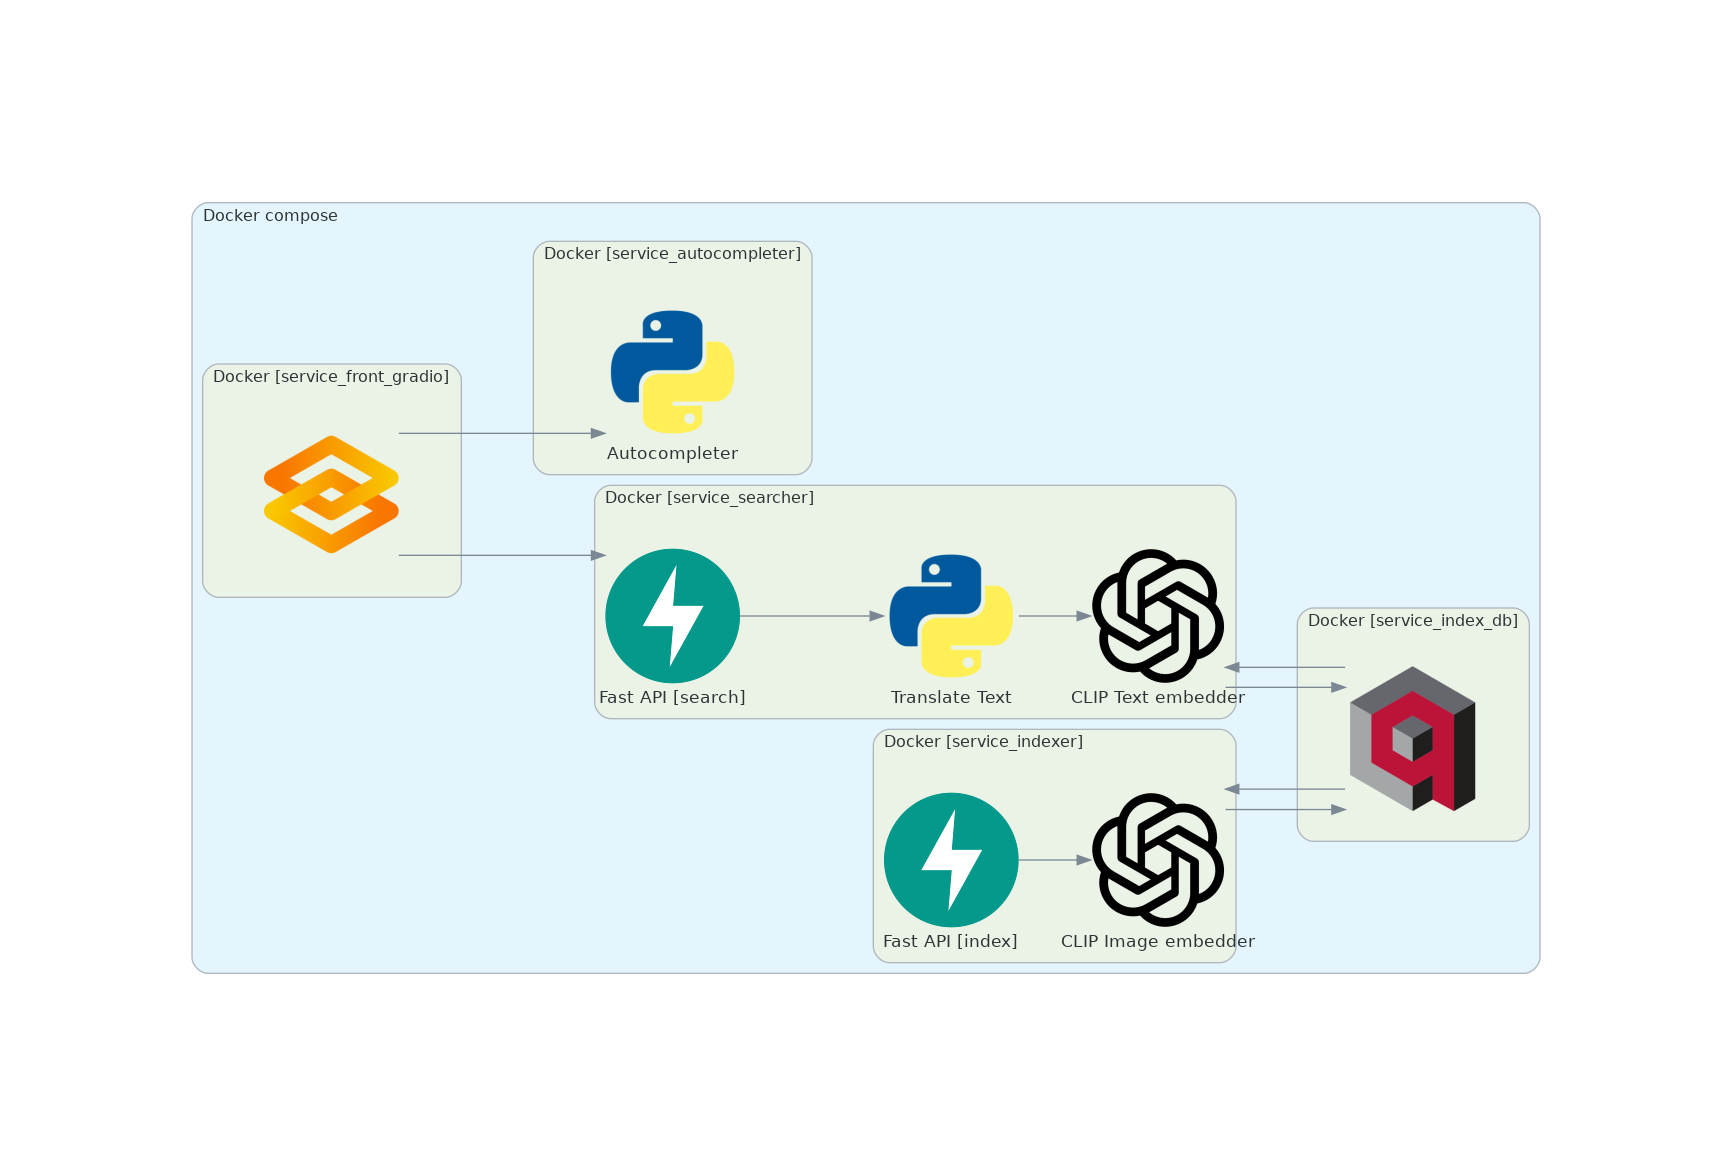

In [68]:
from PIL import Image
'''some code here'''
Image.open("diagrams_image.png")